In [1]:
!pip list

Package                      Version
---------------------------- ------------
absl-py                      2.0.0
anyio                        4.0.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.13.1
beautifulsoup4               4.12.2
bleach                       6.1.0
cachetools                   5.3.2
certifi                      2023.7.22
cffi                         1.16.0
charset-normalizer           3.3.1
colorama                     0.4.6
comm                         0.1.4
contourpy                    1.1.1
cycler                       0.12.1
debugpy                      1.8.0
decorator                    5.1.1
defusedxml                   0.7.1
executing                    2.0.1
fastjsonschema               2.18.1
flatbuffers                  23.5.

### Import some basic dependencies 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import cv2
from sklearn.utils import shuffle
import random
import tensorflow as tf

### create the dataframe

In [2]:
df = pd.read_csv('train_labels.csv')
train_dir = 'train'

In [3]:
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


### Check class distributions

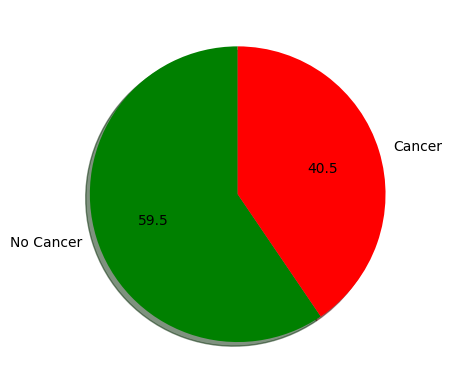

<Figure size 1500x1500 with 0 Axes>

In [4]:
label_counts = df.label.value_counts()
plt.pie(label_counts, labels=['No Cancer', 'Cancer'], startangle=90, autopct='%1.1f', colors=['green', 'red'], shadow=True)
plt.figure(figsize=(15,15))
plt.show()

### Visualize images

In the dataset description, it states: "A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image." Thus, we will keep this 32x32 region in mind throughout the process

In [5]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

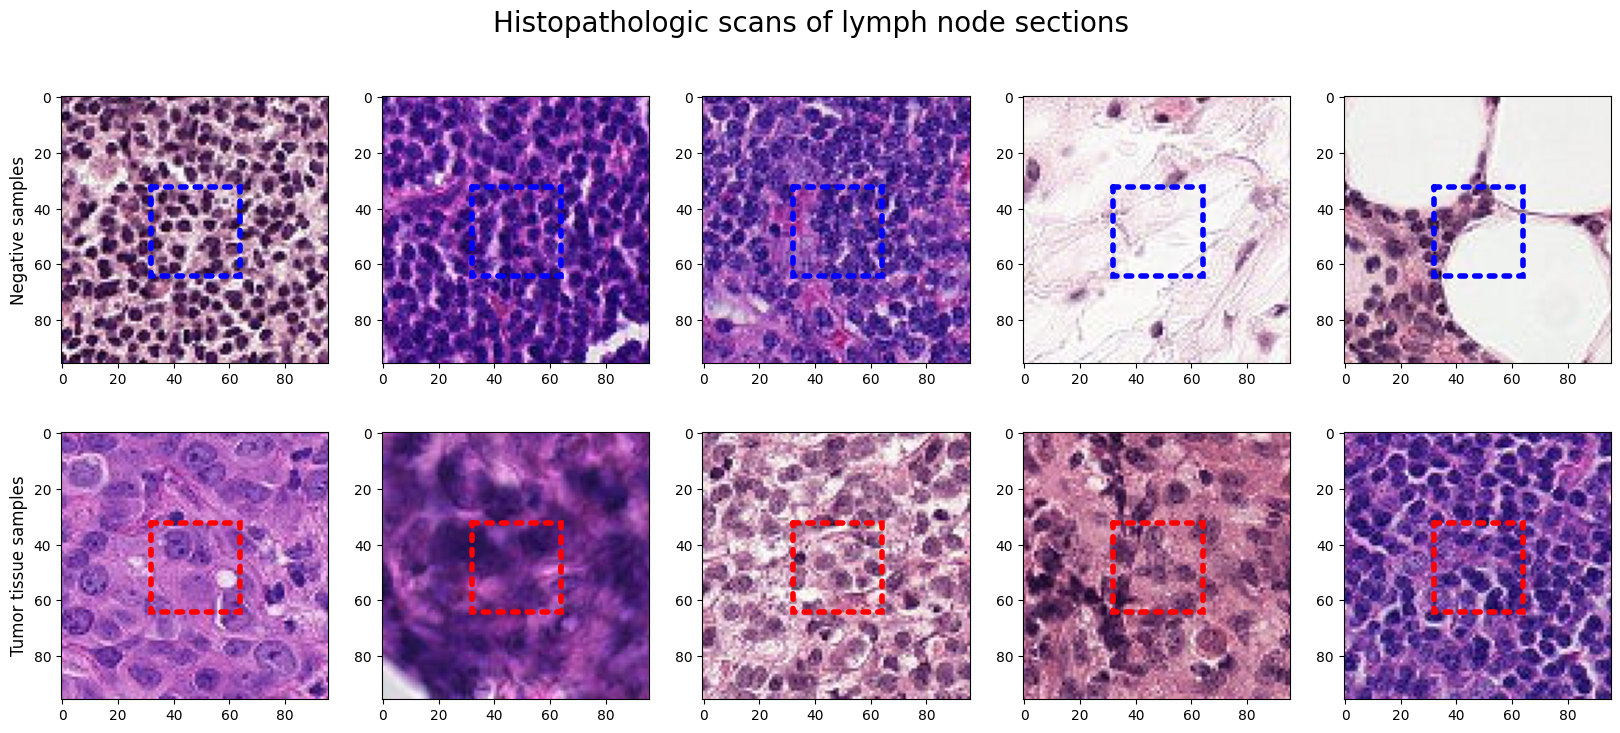

In [6]:
# random sampling
shuffled_data = shuffle(df)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_dir, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_dir, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

## Lets Train a Model

### Dependencies

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
from tqdm import tqdm

In [8]:
np.random.seed(42)

### Dataframe adjustments

We need to make a couple adjsutments to our dataframe. 1, add the .tif extensions to the id column of the df. 2, convert the label from a np.int to a str

In [9]:
df['id'] = df['id'] + '.tif'

In [10]:
df['label'] = df['label'].astype(str)

In [11]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


### Initialize training parameters

In [12]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [13]:
img_size = (96, 96)
batch_size = 64

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True
)

In [15]:
val_datagen = ImageDataGenerator(rescale=1./255)


In [16]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42
)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


### Checking Images again post-augmentations

In [19]:
## check images after augmentations
def plot_random_samples(generator):
    generator_size = len(generator)
    index=random.randint(0,generator_size-1)
    image,label = generator.__getitem__(index)

    sample_number = 10
    fig = plt.figure(figsize = (20,sample_number))
    for i in range(0,sample_number):
        ax = fig.add_subplot(2, 5, i+1)
        ax.imshow(image[i])
        if label[i]==0:
            ax.set_title("Cancerous cells")
        elif label[i]==1:
            ax.set_title("Healthy cells")
    plt.tight_layout()
    plt.show()

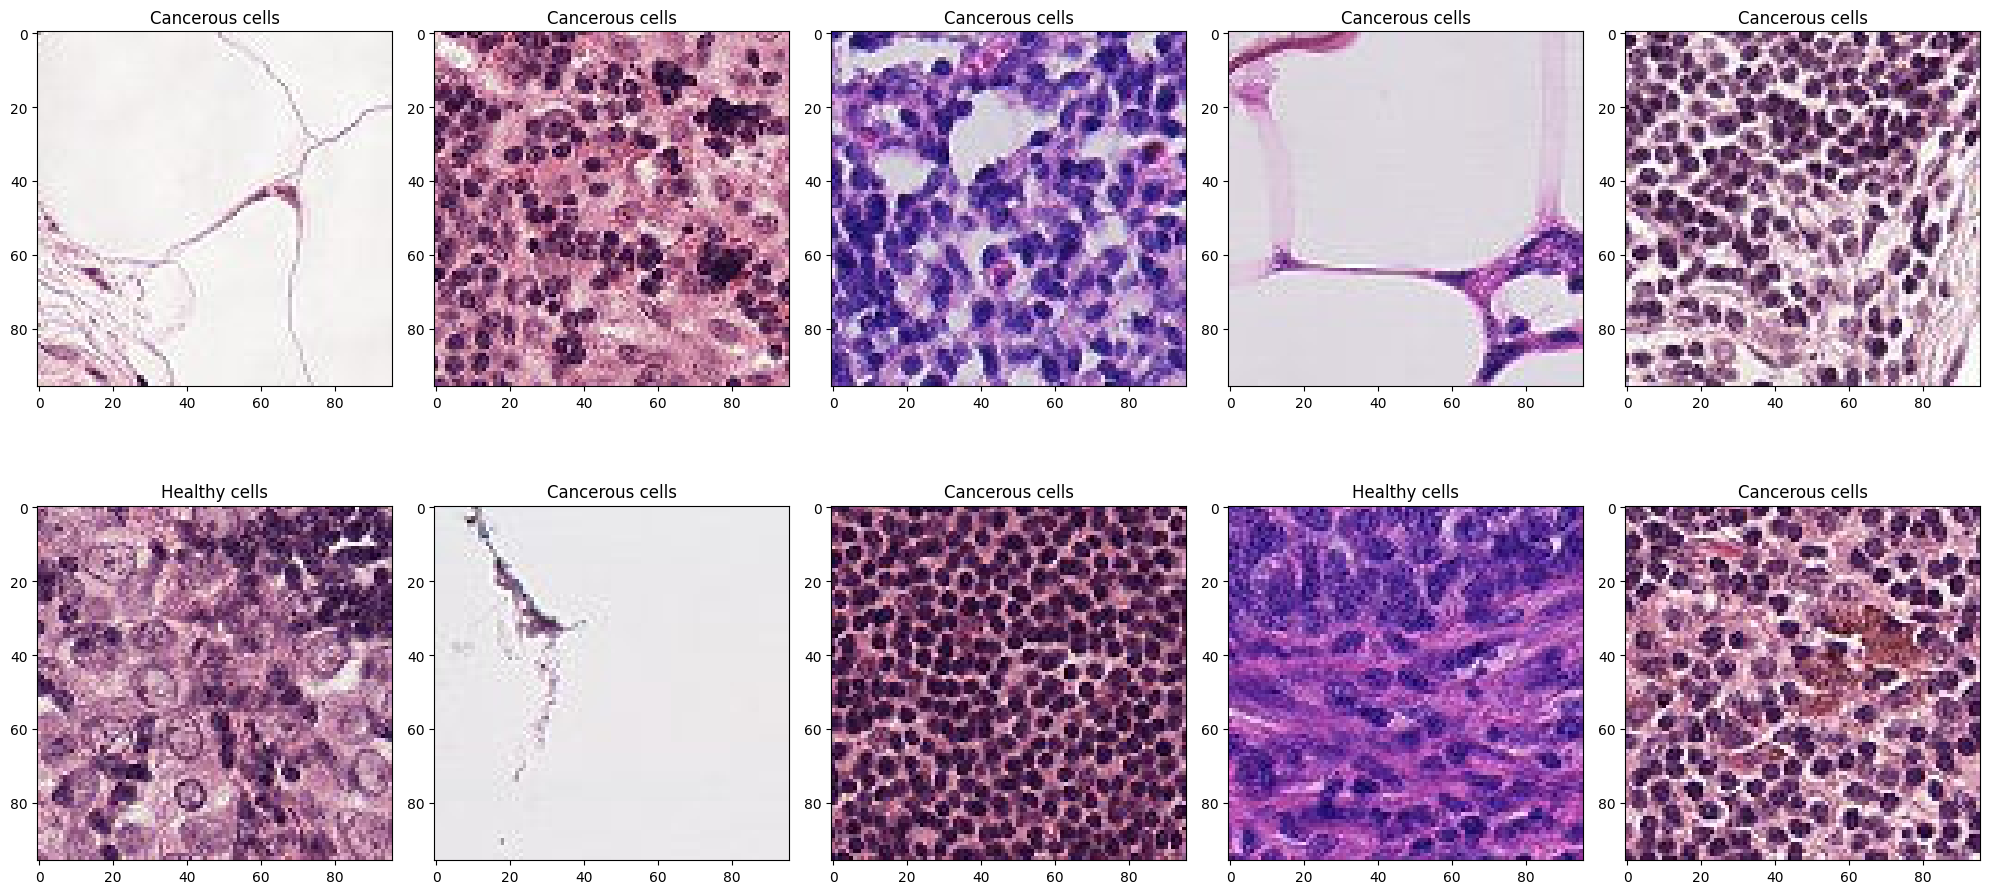

In [20]:
plot_random_samples(val_generator)

### VGG16

In [21]:
from tensorflow.keras.applications import VGG16
pretrained = VGG16(weights='imagenet', include_top=False, input_shape=(96,96,3))
pretrained.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

#### Freeze initial layers, train on last 8

In [23]:
for layer in pretrained.layers[:-8]:
    layer.trainable=False

for layer in pretrained.layers:
    print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x0000026D28F764D0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000026D291F6F50> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000026D291D3CD0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000026D267D4B10> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000026D291F4A90> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000026D29A67310> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000026D29A28610> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000026D288FE610> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000026D288FFD50> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000026D291AF150> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000026D29A90B10> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000026D29A8AD10> True
<

#### Add output layer

In [28]:
model = Sequential()
model.add(pretrained)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 256)               131072    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)              

In [31]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

#### Creating callbacks and checkpoints

In [32]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


In [37]:
# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("GPU not found. Please ensure TensorFlow is configured correctly.")

# Check if GPU is being used for computations
if tf.config.experimental.list_physical_devices('GPU'):
    print('GPU is being used for computations.')
else:
    print('GPU is NOT being used for computations. Please ensure TensorFlow is configured correctly.')

GPU not found. Please ensure TensorFlow is configured correctly.
GPU is NOT being used for computations. Please ensure TensorFlow is configured correctly.


In [38]:
# Define callbacks

checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_best_only=True,
                             save_weights_only=True,
                             monitor='val_accuracy',
                             mode='max',
                             verbose=1)

early_stopping = EarlyStopping(monitor='loss', patience=5, mode='max', verbose=1)

lr_adjust = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[lr_adjust, checkpoint, early_stopping]
)

Epoch 1/20
2750/2750 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.8737
Epoch 1: val_accuracy improved from -inf to 0.88831, saving model to training_1\cp.ckpt
2750/2750 [==============================] - 5977s 2s/step - loss: 0.3067 - accuracy: 0.8737 - val_loss: 0.2695 - val_accuracy: 0.8883 - lr: 0.0010
Epoch 2/20
2750/2750 [==============================] - ETA: 0s - loss: 0.2395 - accuracy: 0.9056
Epoch 2: val_accuracy improved from 0.88831 to 0.89843, saving model to training_1\cp.ckpt
2750/2750 [==============================] - 5983s 2s/step - loss: 0.2395 - accuracy: 0.9056 - val_loss: 0.2641 - val_accuracy: 0.8984 - lr: 0.0010
Epoch 3/20
2750/2750 [==============================] - ETA: 0s - loss: 0.2176 - accuracy: 0.9161
Epoch 3: val_accuracy improved from 0.89843 to 0.92313, saving model to training_1\cp.ckpt
2750/2750 [==============================] - 5987s 2s/step - loss: 0.2176 - accuracy: 0.9161 - val_loss: 0.1975 - val_accuracy: 0.9231 - lr:

#### Model Evaluation

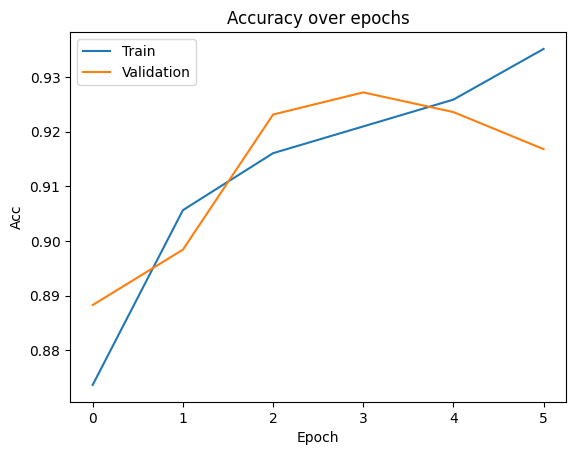

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy over epochs')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

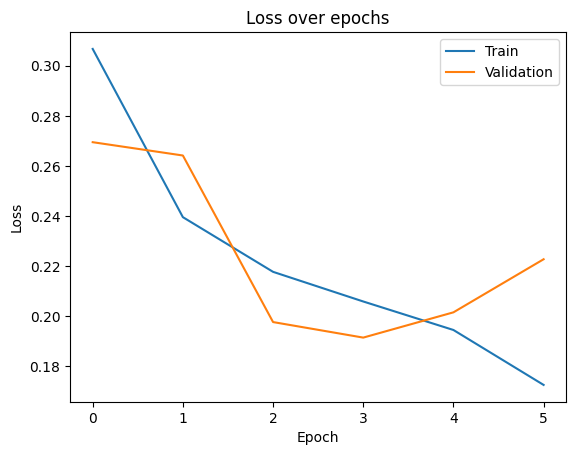

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

#### Save model

In [43]:
model.save('model1.keras')

In [44]:
model.save('model1.h5')

C:\Users\oshan\Machine Learning Projects\Deep Learning\Computer Vision\Histopathologic Cancer Detection\HCP\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
model = tf.keras.models.load_model('model1.keras')

#### Prepare test dataframe

In [22]:
test_df = pd.DataFrame({'id':os.listdir('test')})
test_df.head()

,id
0,00006537328c33e284c973d7b39d340809f7271b.tif
1,0000ec92553fda4ce39889f9226ace43cae3364e.tif
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
3,000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
4,000270442cc15af719583a8172c87cd2bd9c7746.tif


In [27]:
test_datagen = ImageDataGenerator(
    rescale=1. / 255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='test',
    x_col='id',
    y_col=None,
    target_size=(96,96),
    batch_size=1,
    shuffle=False,
    class_mode=None
)

Found 57458 validated image filenames.


#### Model predictions on test set

In [29]:
predictions = model.predict(test_generator, verbose=1)

57458/57458 [==============================] - 1499s 26ms/step


#### Create submission file

In [30]:
predictions = np.transpose(predictions)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_df['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submission_df.head()
submission_df.to_csv('submission.csv', index=False)
